#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import pandas as pd
import numpy as np

import time

import matplotlib.pyplot as plt
# from pandas.plotting import scatter_matrix

# import seaborn as sns
# sns.set(context='talk', style='whitegrid', palette='muted')

# import optuna
from sklearn.model_selection import GridSearchCV 

# import statsmodels.api as sm

# #import random
# #import math
# #from scipy import stats

# import datetime 
# from datetime import datetime, date

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.dummy import DummyClassifier
# from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression  

# # from sklearn.neural_network import MLPRegressor 
from sklearn.linear_model import Ridge
# # from sklearn.linear_model import Lasso
# from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor

# # import xgboost
from catboost import Pool, CatBoostRegressor, cv
# from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline

# from sklearn.utils import shuffle

from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
# from sklearn.metrics import precision_recall_curve, roc_curve

pd.set_option('display.max_columns', 40) #макс кол-во колонок в выводимых данных 
pd.set_option('display.max_rows', 20) #макс кол-во строк в выводимых данных
pd.set_option('display.width', 80) #макс кол-во символов в строке

%matplotlib inline
import warnings
warnings.simplefilter('ignore')
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

from itertools import product
import statsmodels.api as sm

In [2]:
try: 
    df=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]) 
except: 
    df=pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.index.is_monotonic

True

In [5]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Загрузили данные и выполнили их ресемплирование по одному часу.

## Анализ

<AxesSubplot:xlabel='datetime'>

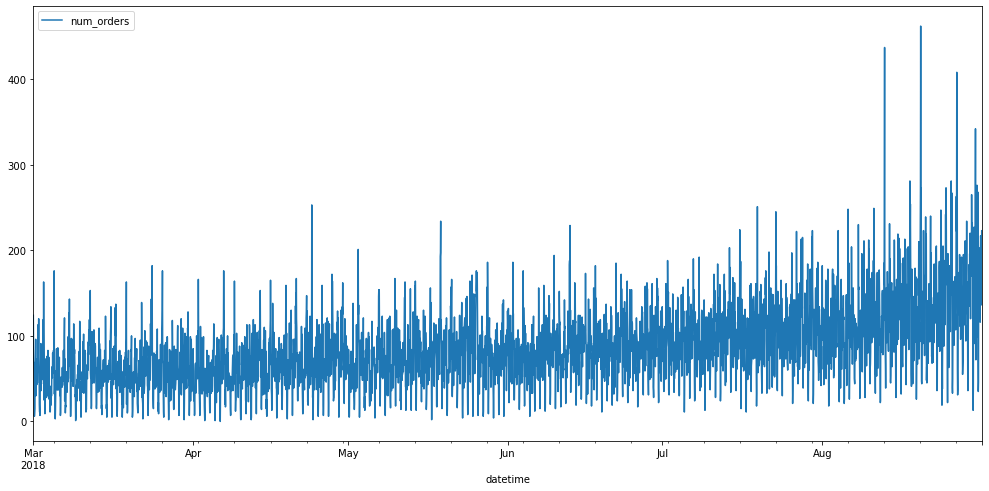

In [7]:
figsize = (17,8)
df.plot(figsize=figsize)

Как выглядит последняя неделя отдельно?

<AxesSubplot:xlabel='datetime'>

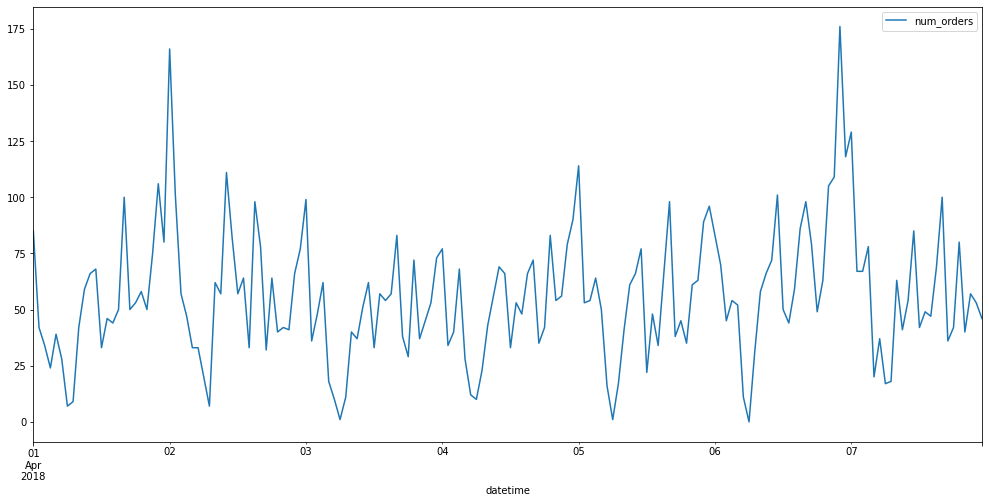

In [8]:
df['2018-04-01':'2018-04-07'].plot(figsize=figsize)

Выделим тренд, сезонность и шум.

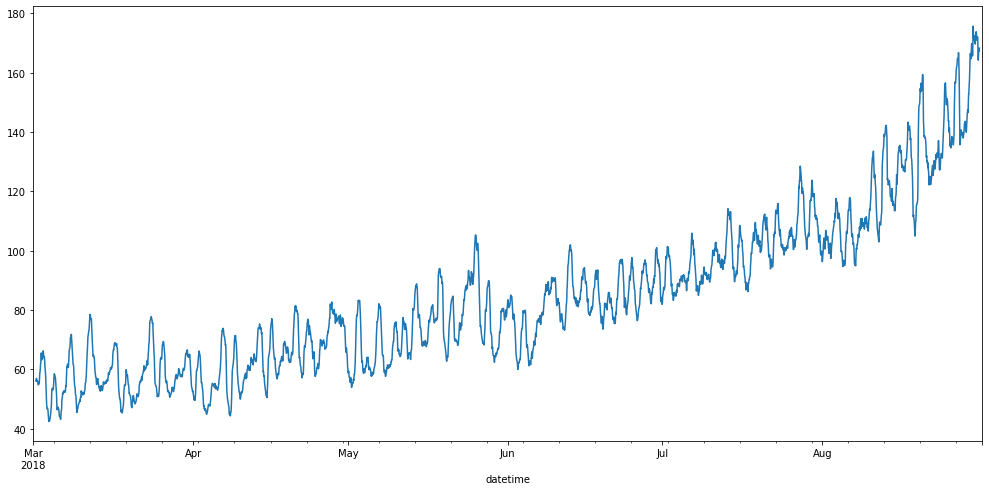

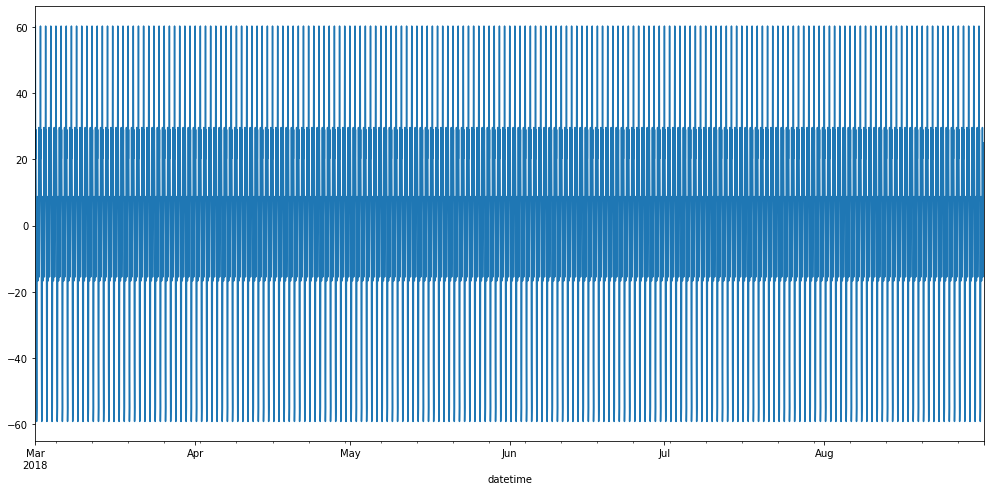

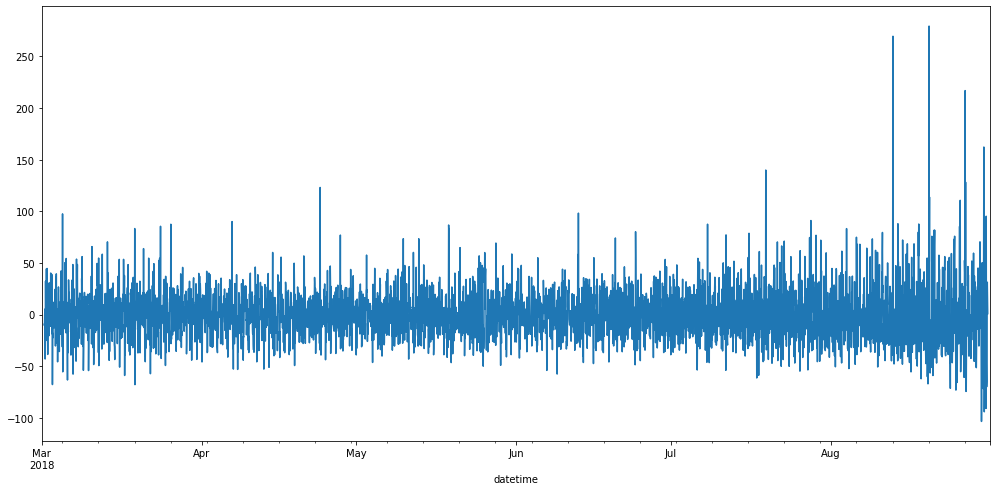

In [9]:
decomposed_df = seasonal_decompose(df)
decomposed_df.trend.plot(figsize=figsize)
plt.show()
decomposed_df.seasonal.plot(figsize=figsize)
plt.show()
decomposed_df.resid.plot(figsize=figsize)
plt.show()

Взглянем на то же самое для последней недели.

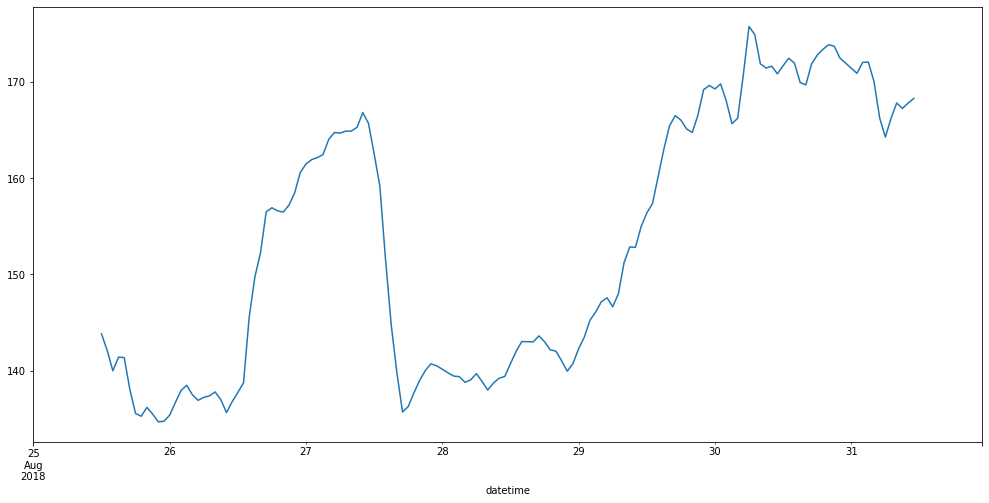

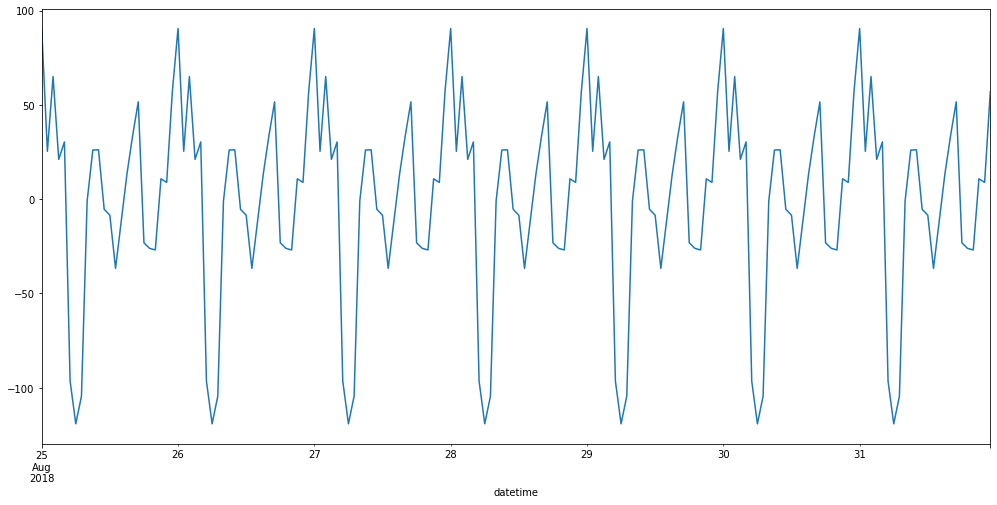

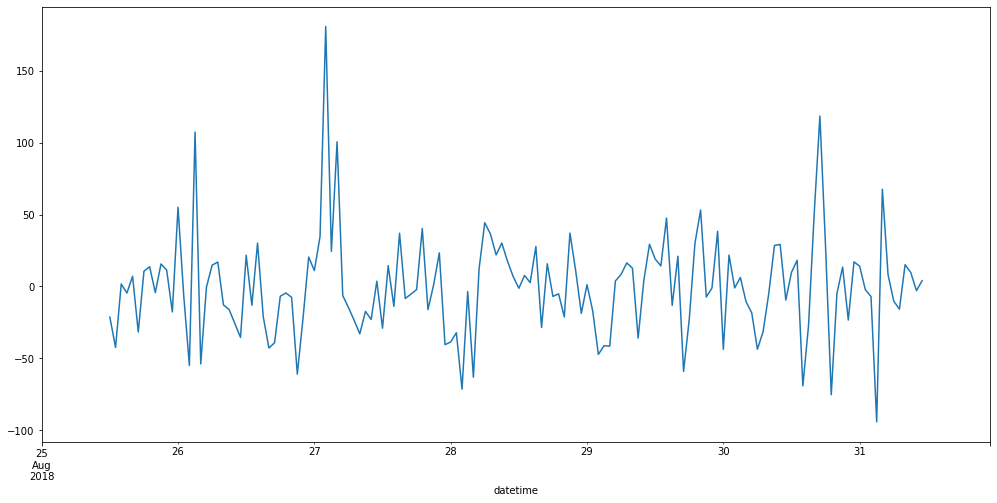

In [10]:
figsize = (17,8)
decomposed_df = seasonal_decompose(df['2018-08-25':'2018-08-31'])
decomposed_df.trend.plot(figsize=figsize)
plt.show()
decomposed_df.seasonal.plot(figsize=figsize)
plt.show()
decomposed_df.resid.plot(figsize=figsize)
plt.show()

Посмотрим на последние два месяца.

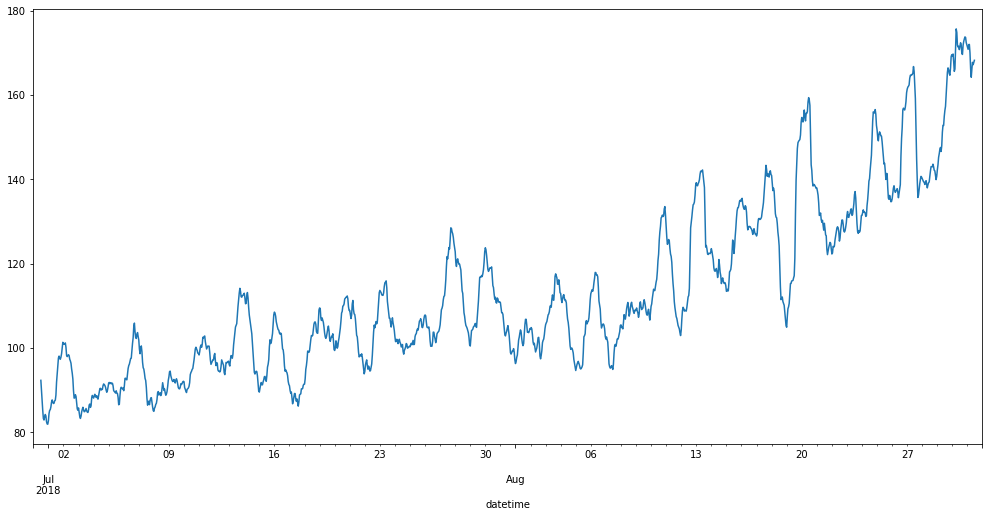

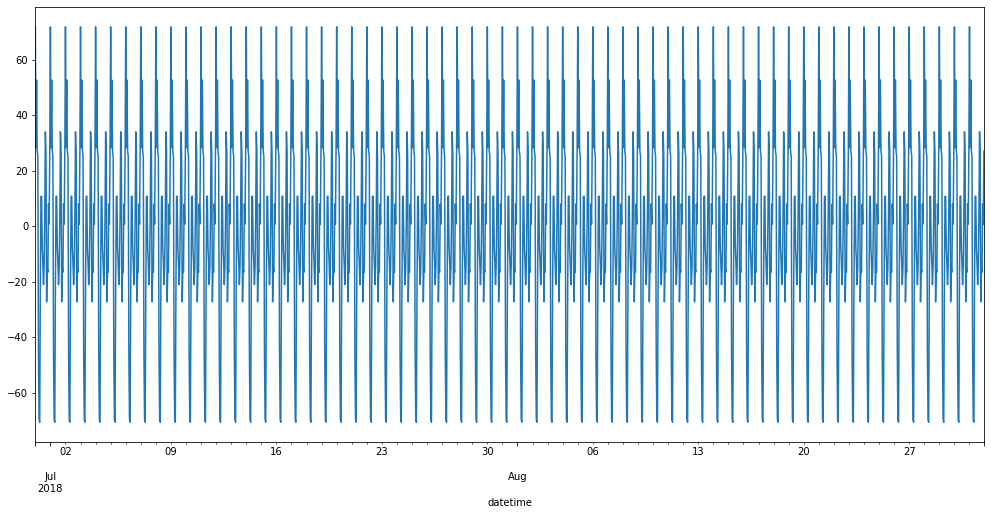

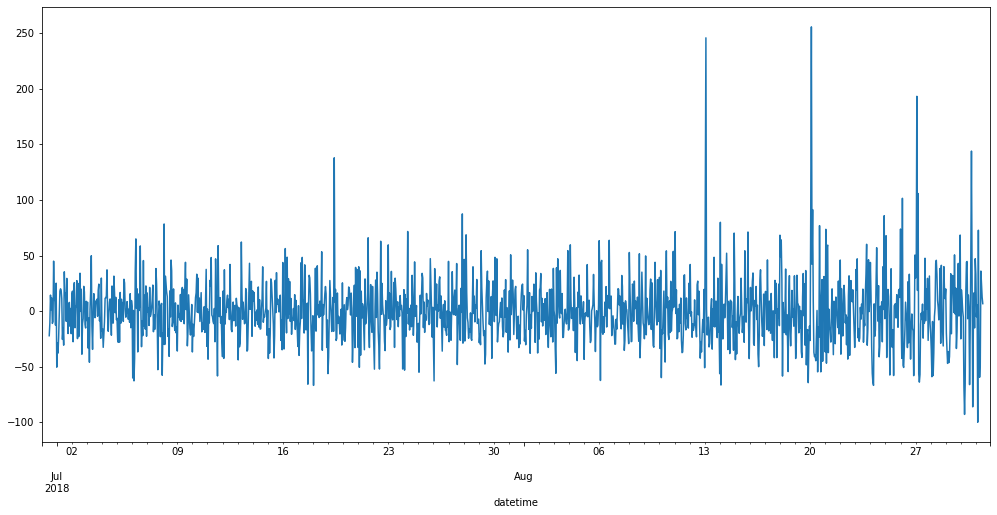

In [11]:
decomposed_df = seasonal_decompose(df['2018-06-30':'2018-08-31'])
decomposed_df.trend.plot(figsize=figsize)
plt.show()
decomposed_df.seasonal.plot(figsize=figsize)
plt.show()
decomposed_df.resid.plot(figsize=figsize)
plt.show()

Дисперсия ряда со временем увеличивается.

Также тренд показывает, что со временем все больше и больше людей пользуется услугой заказа такси.

Рассматривая каждый день отдельно, видим, что такси требуются для ночных рейсов и по наступлению утра намечается спад спроса.

Проверим ряд на стационарность.

In [12]:
ad = adfuller(df['num_orders'], autolag='AIC')[1]
alpha = 0.05
display(ad)
if ad < alpha: 
    print ('Ряд стационарен')
else: 
    print ('Ряд нестационарен')

0.028940051402612035

Ряд стационарен


Исследуем признаки, которые понадобятся нам для моделей.

- признак day, т.к. мы видим ежедневную "сезонность", 
- признак day of week, т.к. видим увеличение в середине и к концу недели количества заказов, 
- признак month, т.к. данные отличаются также помесячно.

Для определения lag признаков найдем разницу в часах между максимальным пиком ночью и минимальным пиком в пределах "сезона".

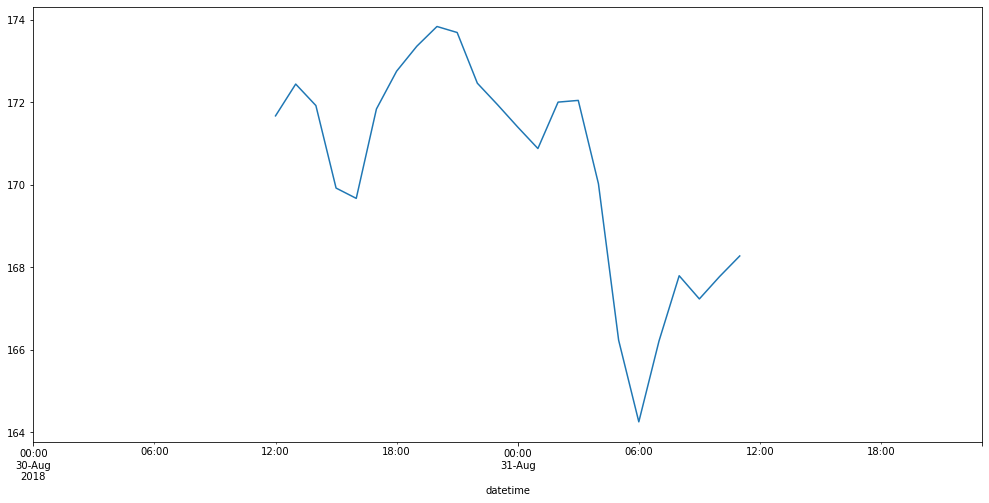

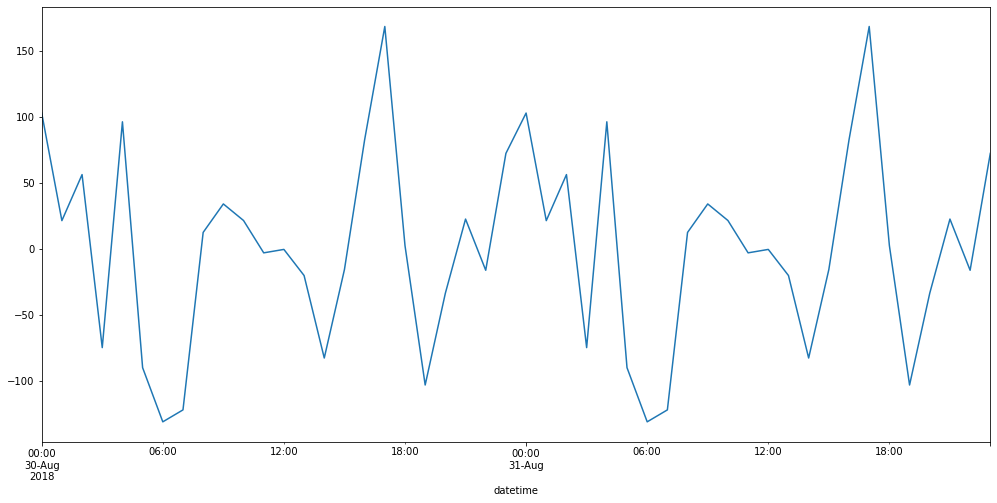

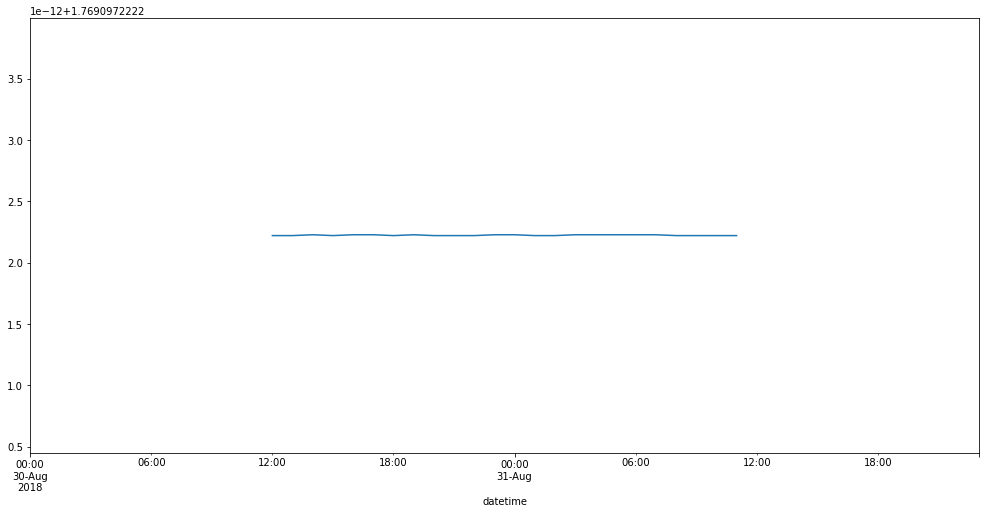

In [13]:
decomposed_df = seasonal_decompose(df['2018-08-30':'2018-08-31'])
decomposed_df.trend.plot(figsize=figsize)
plt.show()
decomposed_df.seasonal.plot(figsize=figsize)
plt.show()
decomposed_df.resid.plot(figsize=figsize)
plt.show()

In [14]:
decomposed_df_24h = seasonal_decompose(df['2018-08-30':'2018-08-31'])

In [15]:
decomposed_df_24h.seasonal.idxmax() - decomposed_df_24h.seasonal.idxmin()

Timedelta('0 days 11:00:00')

Лаг 22 часа до следующего максимума:

In [16]:
max_lag = 22

Для того, чтобы определить размер rolling_mean проверим, какое окно в скользящем среднем лучше всего иллюстрирует данные.

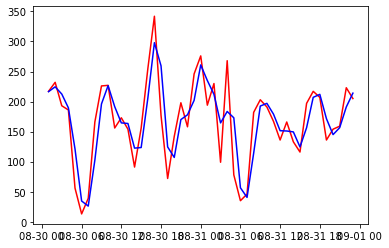

37.20937024517551


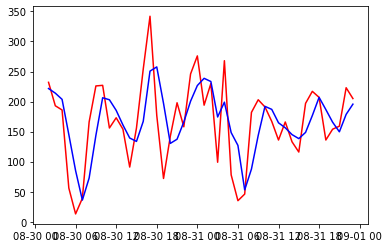

53.29049457074125


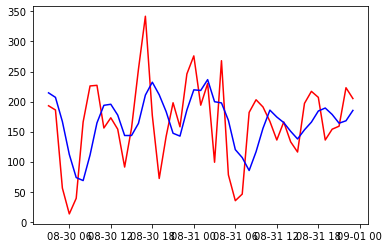

63.744498673306005


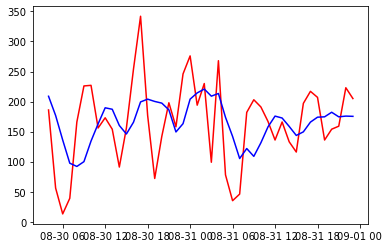

67.59614701230456


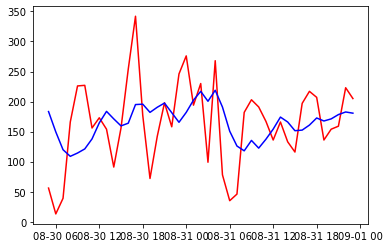

69.73090580801458


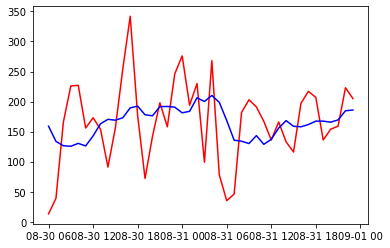

67.92390557450068


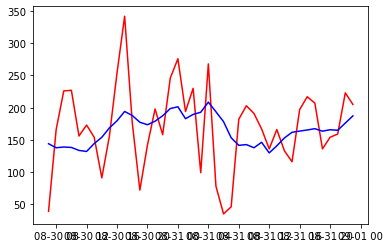

62.926871513977126


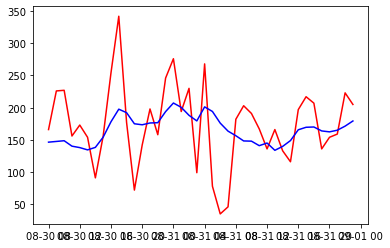

59.28822671627558


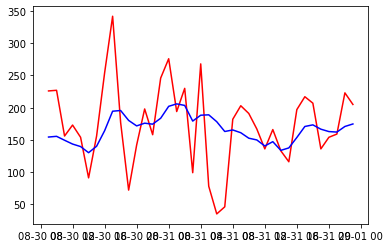

60.03829120033655


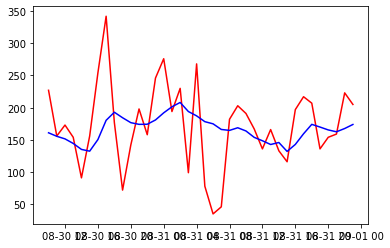

62.14800313100127


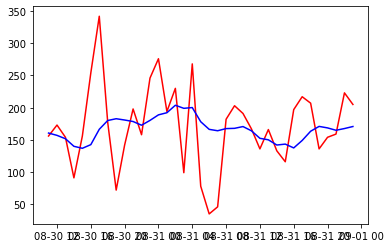

63.27369910554068


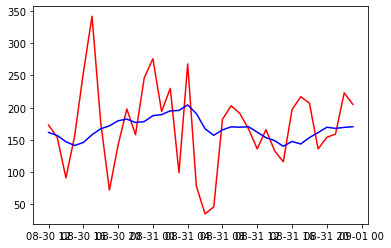

64.5242998632826


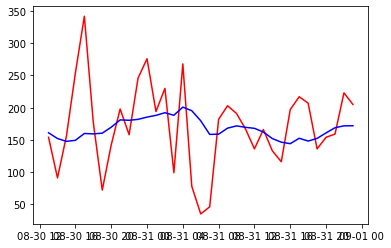

65.5193036785263


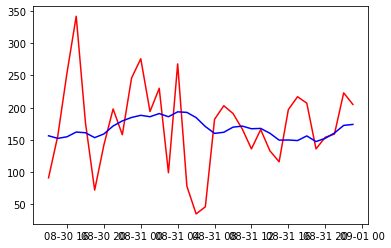

66.57033039492059


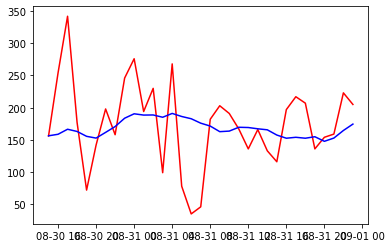

66.3901756391826


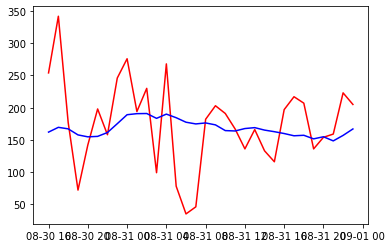

66.786833110948


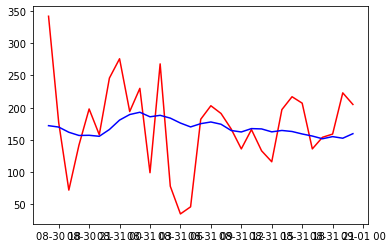

65.9555857159695


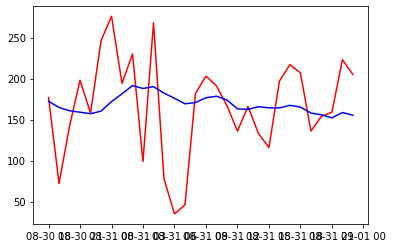

59.95063065843002


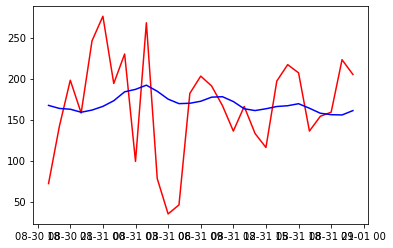

61.62310079608245


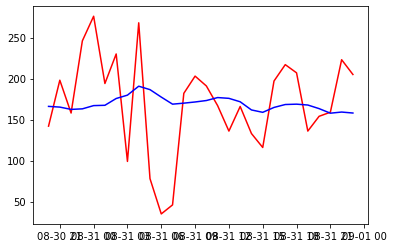

60.295350032185105


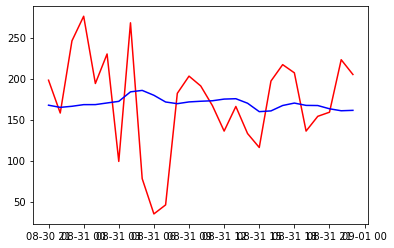

61.584824578009915


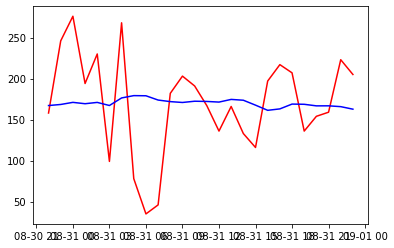

62.2411084136485


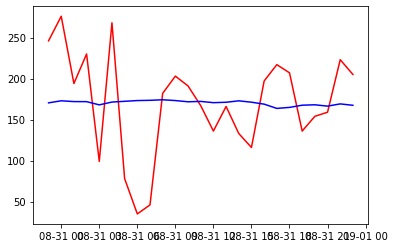

62.204006324173186


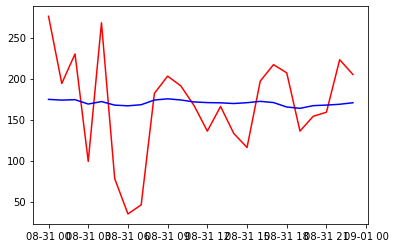

59.35472853951908


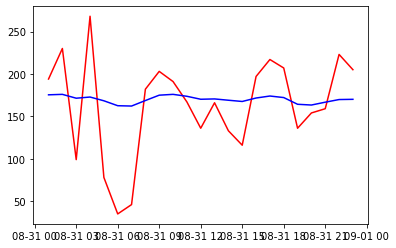

55.395072289503794


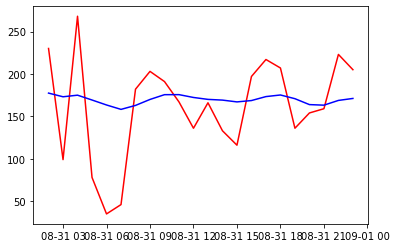

56.59878804647867


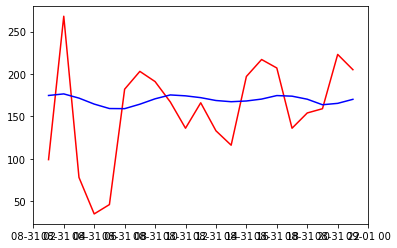

57.99764423770521


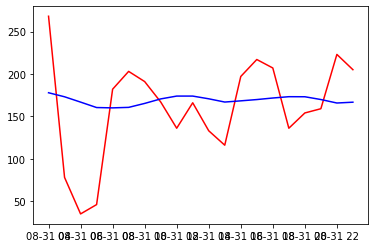

57.88077099016712


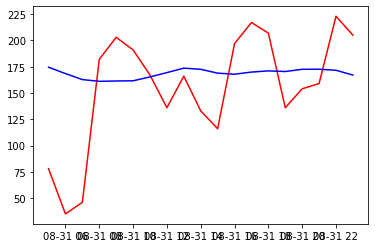

55.952374798698536


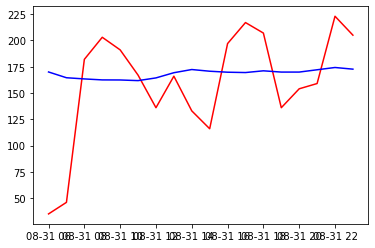

52.57135722880583


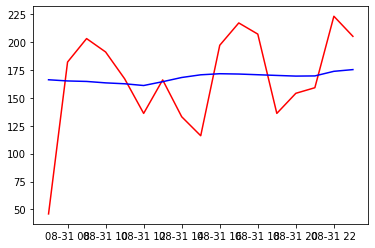

42.49692354782181


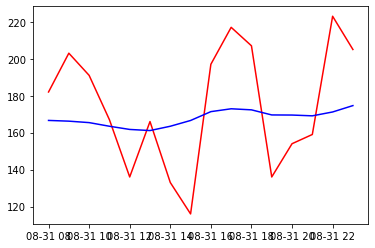

30.931430392629238


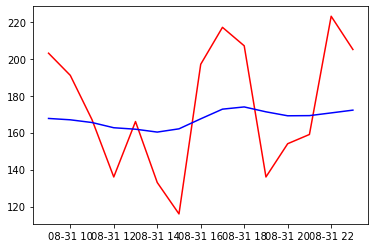

31.350481822389316


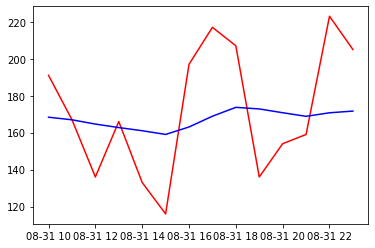

31.774131803954045


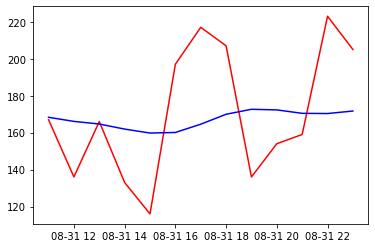

33.78557444177727


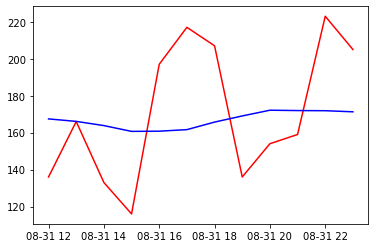

35.77340048315332


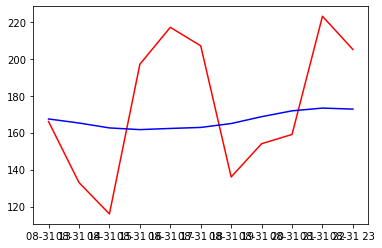

35.84313191905542


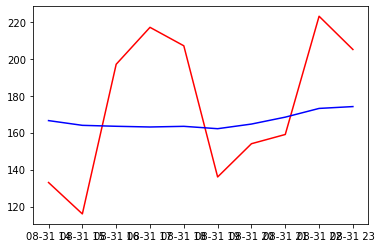

36.996836050019624


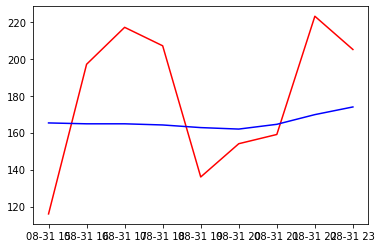

37.472419487167116


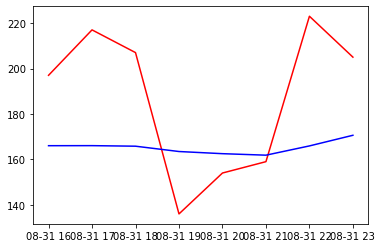

36.27573037059744


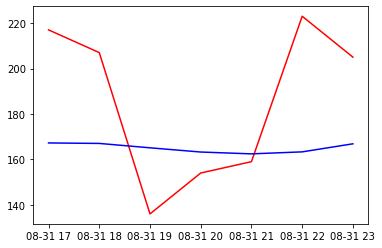

37.86404976996232


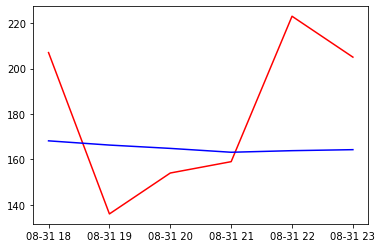

35.86913849604602


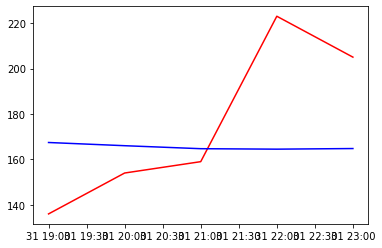

35.22933571671942


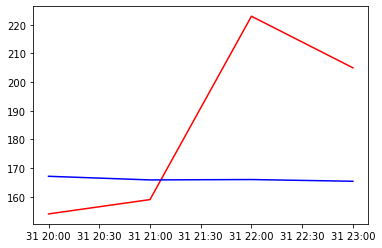

35.48519252996789


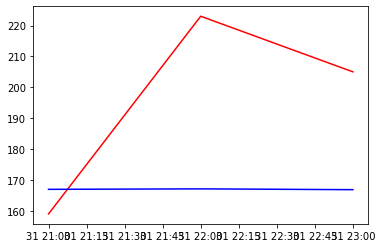

39.339261618971676


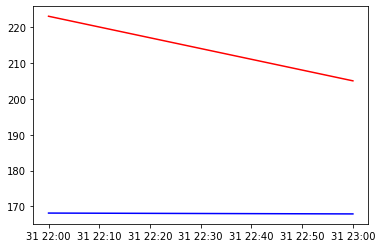

46.818502318507804


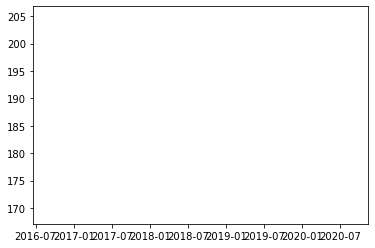

36.08333333333334


In [17]:
rolling_mean_size_dict = {}
for rolling_mean_size in range(2,49):
    data = df['2018-08-30':'2018-08-31'].copy()
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    index = data.index
    num_orders = data['num_orders']
    rolling_mean = data['rolling_mean']
    plt.plot(index, num_orders, 'r-', index, rolling_mean, 'b-')
    plt.show()
    RMSE = mean_squared_error(num_orders, rolling_mean)**0.5
    print(RMSE)
    rolling_mean_size_dict[rolling_mean_size] = RMSE

In [18]:
rolling_mean_size = min(rolling_mean_size_dict.keys(), key=(lambda x: rolling_mean_size_dict[x]))
rolling_mean_size

33

Данные были проанализированы, были выявлены тренды и сезонность.

Перейдем к подготовке данных для обучения моделей, к созданию и обучению моделей. 

## Обучение

Создадим признаки:

In [19]:
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

Используем TimeSeriesSplit вместо кросс-валидации.

In [20]:
df_taxi = df.copy()
make_features(df_taxi,'num_orders', max_lag, rolling_mean_size)

train, test = train_test_split(df_taxi, shuffle=False, test_size=0.1, random_state=7777777)
train = train.dropna()

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

In [21]:
def cv_time_series_rmse(regressor, data, target_column, n_splits, max_train_size):
    tscv = TimeSeriesSplit(n_splits = n_splits, max_train_size = max_train_size)
    RMSE = 0.0
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        train_features = train.drop(target_column, axis=1)
        train_target = train[target_column]
        test_features = test.drop(target_column, axis=1)
        test_target = test[target_column]
        regressor.fit(train_features, train_target)
        RMSE += mean_squared_error(test_target, regressor.predict(test_features)) ** 0.5
    return RMSE / n_splits

In [22]:
cv_train_test_split = (train.shape[0] * 4 // 5)
cv_splits = 3
cv_time_series_rmse(regressor=LinearRegression(), 
                    data=train, 
                    target_column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split)

31.023074504866088

Создали функцию для кроссвалидации временных рядов.

Рассмотрим следующие регрессоры для обучения модели:
- LinearRegression
- Ridge
- DecisionTreeRegressor
- ExtraTreesRegressor
- CatBoostRegressor
- LGBMRegressor

#### LinearRegression

In [23]:
start_time = time.time()
regressor = LinearRegression()
cv_RMSE_LR = cv_time_series_rmse(regressor=regressor, 
                                 data=train, 
                                 target_column='num_orders', 
                                 n_splits=cv_splits, 
                                 max_train_size=cv_train_test_split)
elapsed_time = time.time() - start_time 
print('Mean RMSE of LinearRegression =', cv_RMSE_LR)
print('Time consumption, sec =', elapsed_time)

Mean RMSE of LinearRegression = 31.023074504866088
Time consumption, sec = 0.01562643051147461


#### Ridge

Используем TimeSeriesSplit и напишем функцию получения RMSE с помощью кросс-валидации при таком разделении на фолды для этой и следующих моделей.

In [24]:
tscv = TimeSeriesSplit(n_splits=3)
tscv.split(train_features)
all_splits = list(tscv.split(train_features, train_target))

def evaluate(model, X, y, cv):
    cv_results = cross_validate(model, X, y, cv=cv, scoring=['neg_root_mean_squared_error'])
    rmse = -cv_results['test_neg_root_mean_squared_error']
    return rmse.mean()

In [25]:
X = train_features
y = train_target

Подберем регрессор.

In [26]:
alpha_list = [0.1, 1, 10, 100, 1000]
solver_list = ['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']
best_score = 1000000
best_alpha = None
best_solver = None 

start_time = time.time()
for alpha_i in alpha_list: 
    for solver_i in solver_list: 
        model = Ridge (alpha=alpha_i, solver=solver_i)
        score = evaluate(model, X, y, cv=tscv)
        if score < best_score: 
            best_score = score 
            best_alpha = alpha_i
            best_solver = solver_i
print("Best score and parameters set found:")
print('Grid:', best_alpha, best_solver)
print('RMSE:', best_score)
elapsed_time = time.time() - start_time     
print()
print('Time consumption, sec =', elapsed_time)

Best score and parameters set found:
Grid: 0.1 auto
RMSE: 31.023163557796835

Time consumption, sec = 0.5919156074523926


In [27]:
start_time = time.time()
regressor = Ridge(alpha=best_alpha, solver=best_solver)
cv_RMSE_R = cv_time_series_rmse(regressor=regressor, 
                                data=train, 
                                target_column='num_orders', 
                                n_splits=cv_splits, 
                                max_train_size=cv_train_test_split)
elapsed_time = time.time() - start_time     
print('Mean RMSE of Ridge =', cv_RMSE_R)
print()
print('Time consumption, sec =', elapsed_time)

Mean RMSE of Ridge = 31.023163557796835

Time consumption, sec = 0.03125929832458496


#### DecisionTreeRegressor

In [28]:
max_depth_list = [x for x in range(2, 21)]
criterion_list = ['mse']
random_state = [7777777]
max_depth_list = [x for x in range(2, 21)]

best_max_depth_dtr = 0
best_score = 10000

start_time = time.time()
for max_depth_i in max_depth_list: 
    model = DecisionTreeRegressor (criterion='mse', random_state=7777777, max_depth=max_depth_i)
    score = evaluate(model, X, y, cv=tscv)
    if score < best_score: 
        best_score = score 
        best_max_depth_dtr = max_depth_i

print("Best score and parameters set found:")
print('Grid:', best_max_depth_dtr)
print('RMSE:', best_score)
elapsed_time = time.time() - start_time     
print()
print('Time consumption, sec =', elapsed_time)

Best score and parameters set found:
Grid: 8
RMSE: 35.29935201859701

Time consumption, sec = 1.9096310138702393


In [29]:
start_time = time.time()
regressor = DecisionTreeRegressor(criterion='mse', random_state=7777777, max_depth=best_max_depth_dtr)
cv_RMSE_DTR = cv_time_series_rmse(regressor=regressor, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
elapsed_time = time.time() - start_time     
print('Mean RMSE of DecisionTreeRegressor =', cv_RMSE_DTR)
print()
print('Time consumption, sec =', elapsed_time)

Mean RMSE of DecisionTreeRegressor = 35.29935201859701

Time consumption, sec = 0.09377789497375488


#### ExtraTreesRegressor

In [30]:
start_time = time.time()

max_depth_list = [x for x in range(2, 21)]
criterion_list = ['mse']
random_state = [7777777]
max_depth_list = [x for x in range(2, 21)]

best_max_depth_etr = 0
best_score = 10000

start_time = time.time()
for max_depth_i in max_depth_list: 
    model = ExtraTreesRegressor(criterion='mse', random_state=7777777, max_depth=max_depth_i)
    score = evaluate(model, X, y, cv=tscv)
    if score < best_score: 
        best_score = score 
        best_max_depth_etr = max_depth_i

print("Best score and parameters set found:")
print('Grid:', best_max_depth_etr)
print('RMSE:', best_score)
elapsed_time = time.time() - start_time     
print()
print('Time consumption, sec =', elapsed_time)


Best score and parameters set found:
Grid: 15
RMSE: 29.276668743904548

Time consumption, sec = 37.59906482696533


In [31]:
start_time = time.time()
regressor = ExtraTreesRegressor(criterion='mse', random_state=7777777, max_depth=best_max_depth_etr)
cv_RMSE_ETR = cv_time_series_rmse(regressor=regressor, 
                                data=train, 
                                target_column='num_orders', 
                                n_splits=cv_splits, 
                                max_train_size=cv_train_test_split)
elapsed_time = time.time() - start_time 
print('Mean RMSE of ExtraTreesRegressor =', cv_RMSE_ETR)
  
print()
print('Time consumption, sec =', elapsed_time)


Mean RMSE of ExtraTreesRegressor = 29.276668743904548

Time consumption, sec = 2.830085039138794


#### CatBoostRegressor

In [32]:
start_time = time.time()

learning_rate_list = [x/10 for x in range(1, 6)]
best_learning_rate_cbr = 0
best_score = 10000

start_time = time.time()
for learning_rate_i in learning_rate_list: 
    model = CatBoostRegressor(verbose=False, random_state=7777777, learning_rate=learning_rate_i)
    score = evaluate(model, X, y, cv=tscv)
    if score < best_score: 
        best_score = score 
        best_learning_rate_cbr = learning_rate_i

print("Best score and parameters set found:")
print('Grid:', best_learning_rate_cbr)
print('RMSE:', best_score)
elapsed_time = time.time() - start_time     
print()
print('Time consumption, sec =', elapsed_time)

Best score and parameters set found:
Grid: 0.1
RMSE: 29.914253983315756

Time consumption, sec = 71.38504457473755


In [33]:
start_time = time.time()
regressor = CatBoostRegressor(verbose=False, random_state=7777777, learning_rate=best_learning_rate_cbr)
cv_RMSE_CBR = cv_time_series_rmse(regressor=regressor, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
elapsed_time = time.time() - start_time
print('Mean RMSE of CatBoostRegressor =', cv_RMSE_CBR)
print()
print('Time consumption, sec =', elapsed_time)

Mean RMSE of CatBoostRegressor = 29.914253983315756

Time consumption, sec = 14.363214015960693


#### LGBMRegressor

In [34]:
start_time = time.time()

learning_rate_list = [x/10 for x in range(1, 6)]
best_learning_rate_lgbmr = 0
best_score = 10000

start_time = time.time()
for learning_rate_i in learning_rate_list: 
    model = LGBMRegressor(random_state=7777777, learning_rate=learning_rate_i)
    score = evaluate(model, X, y, cv=tscv)
    if score < best_score: 
        best_score = score 
        best_learning_rate_lgbmr = learning_rate_i

print("Best score and parameters set found:")
print('Grid:', best_learning_rate_lgbmr)
print('RMSE:', best_score)
elapsed_time = time.time() - start_time     
print()
print('Time consumption, sec =', elapsed_time)

Best score and parameters set found:
Grid: 0.1
RMSE: 29.995285783705427

Time consumption, sec = 1.6924364566802979


In [35]:
start_time = time.time()
regressor = LGBMRegressor(random_state=7777777, learning_rate=best_learning_rate_lgbmr)
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LGBMR = cv_time_series_rmse(regressor=regressor, 
                                    data=train, 
                                    target_column='num_orders', 
                                    n_splits=cv_splits, 
                                    max_train_size=cv_train_test_split)
print('Mean RMSE of LGBMRegressor =', cv_RMSE_LGBMR)
elapsed_time = time.time() - start_time
print()
print('Time consumption, sec =', elapsed_time)

# Train for root_mean_squared_error

Mean RMSE of LGBMRegressor = 29.995285783705427

Time consumption, sec = 0.45235228538513184


Мы создали и обучили модели, используя сгенерированные признаки. 

## Тестирование

Сравним предсказания созданных моделей с тестовыми данными.

#### Linear Regression

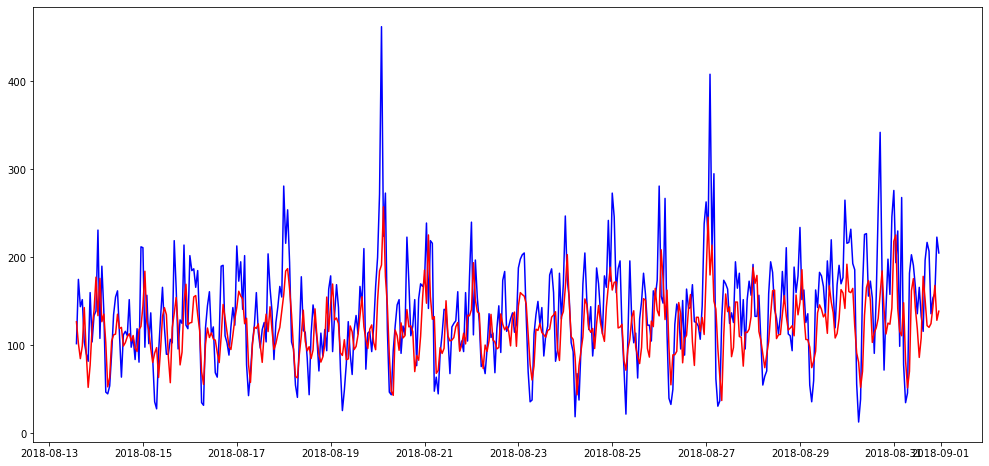

In [36]:
model = LinearRegression()
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_LR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

#### Ridge

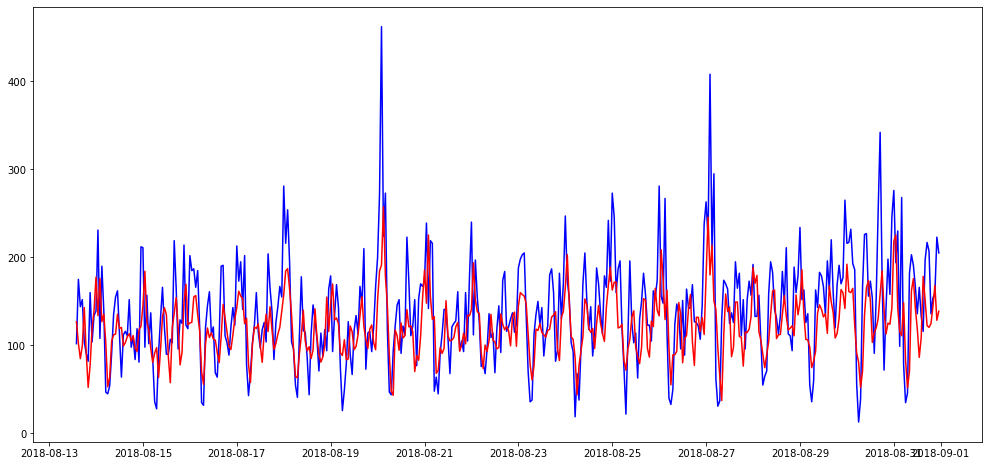

In [37]:
model = Ridge(alpha=best_alpha, solver=best_solver)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_R = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

#### DecisionTreeRegressor

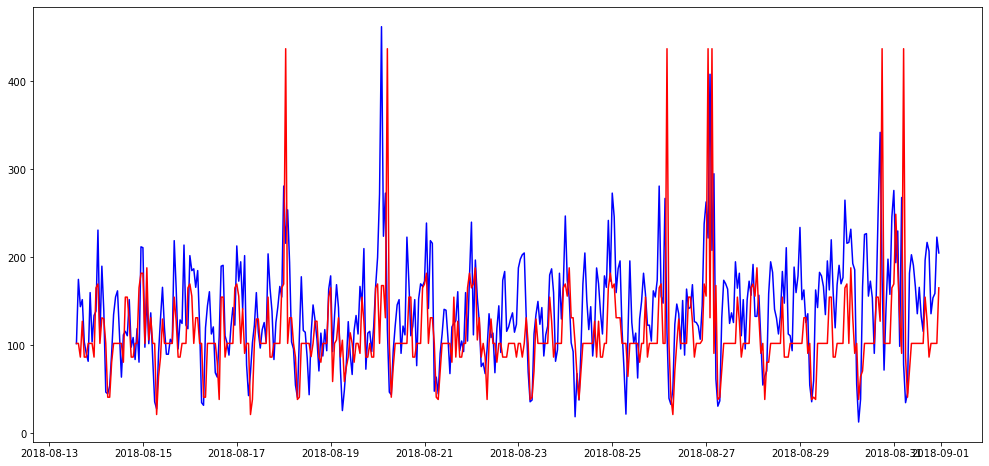

In [38]:
model = DecisionTreeRegressor(criterion='mse', random_state=7777777, max_depth=best_max_depth_dtr)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_DTR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

#### ExtraTreeRegressor

In [39]:
# scaler = StandardScaler()
# scaler.fit(train_features) 
# train_features1 = scaler.transform(train_features)
# test_features1 = scaler.transform(test_features) 

Испробованное масштабирование никак не улучшает показатели ни одной из моделей.

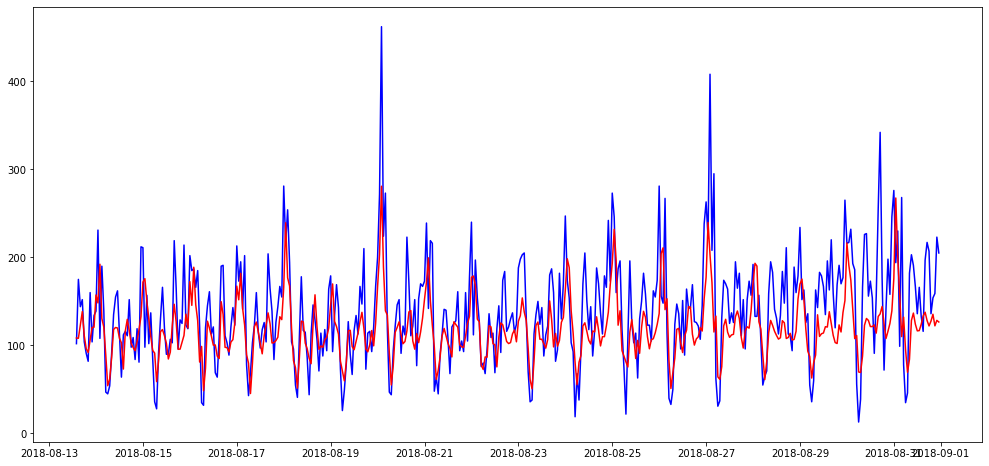

In [40]:
model = ExtraTreesRegressor(criterion='mse', random_state=7777777, max_depth=best_max_depth_etr)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_ETR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

#### CatBoostRegressor

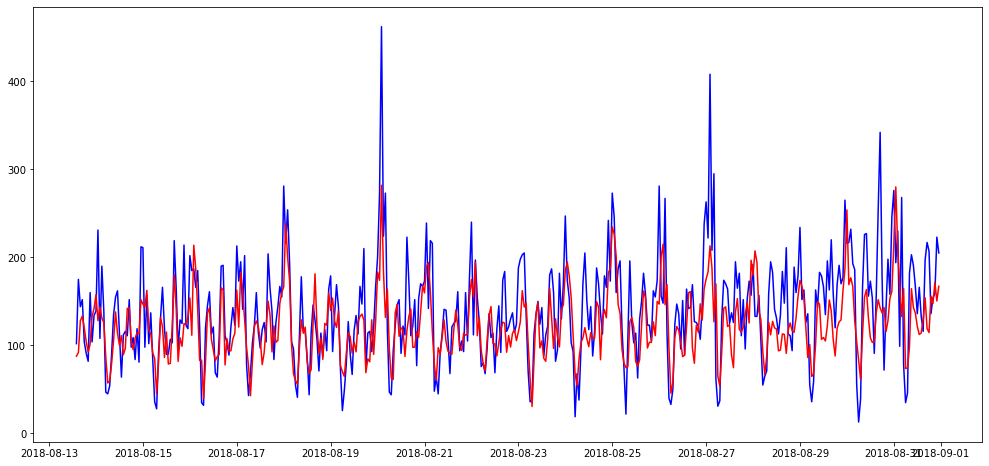

In [41]:
model = CatBoostRegressor(verbose=False, random_state=7777777, learning_rate=best_learning_rate_cbr)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_CBR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

#### LGBMRegressor

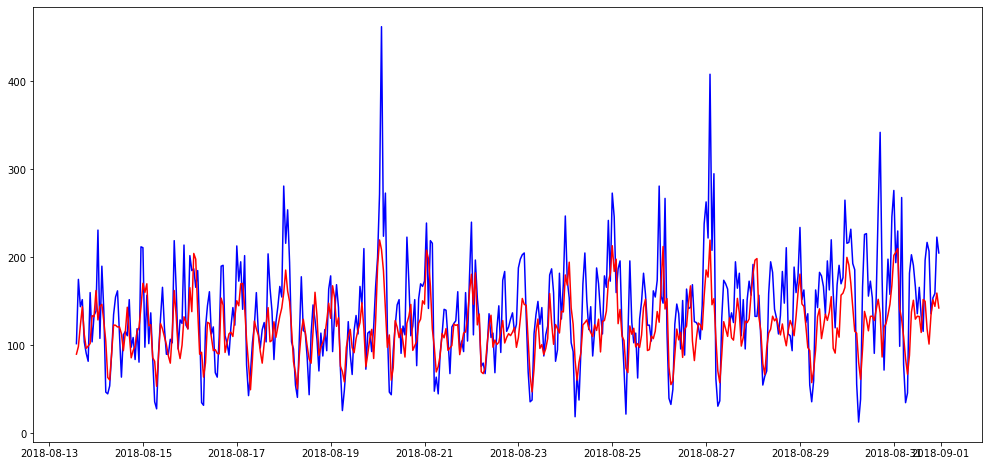

In [42]:
model = LGBMRegressor(random_state=7777777, learning_rate=best_learning_rate_lgbmr)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_LGBMR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

In [43]:
print('LinearRegression:', final_RMSE_LR)
print('Ridge:', final_RMSE_R)
print('DecisionTreeRegression:', final_RMSE_DTR)
print('ExtraTreeRegression:', final_RMSE_ETR)
print('CatBoostRegressor:', final_RMSE_CBR)
print('LGBMRegressor:', final_RMSE_LGBMR)

LinearRegression: 50.6040002141742
Ridge: 50.60371863204009
DecisionTreeRegression: 67.73142760380118
ExtraTreeRegression: 48.02569372071238
CatBoostRegressor: 45.46678470023124
LGBMRegressor: 46.31189218616602


#### Вывод:

- CatBoostRegressor и LGBMRegressor показывают лучшие результаты, из них CatBoostRegressor наилучшие. 
- Мы достигли целевого значения не более 48 для метрики. DecisionTreeRegression, очевидно, переобучилась.